In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [64]:
df = pd.read_csv("log_eth1.csv")

In [3]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [4]:
tdf = timeseries_to_supervised(df['spot_price'])
tdf.columns = ['spot_price_t_1','spot_price_t']
tdf.head()

,spot_price_t_1,spot_price_t
0,0.00,406.29
1,406.29,406.29
2,406.29,406.29
3,406.29,406.29
4,406.29,406.29


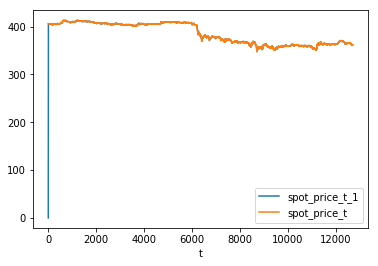

In [7]:
plt.show(tdf.plot(x='t', y=['spot_price_t_1','spot_price_t']))

In [6]:
tdf = pd.concat([tdf,df['t']],axis=1)

In [8]:
len(df)

12696

In [9]:
(tdf['spot_price_t'] - tdf['spot_price_t_1']).sum()

361.87

In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [1]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


SyntaxError: invalid syntax (pywrap_tensorflow_internal.py, line 114)

In [7]:
# fix random seed for reproducibility
np.random.seed(7)

In [8]:
df.head()

,t,spot_price,act_dol,act_ETH,net_worth,profit,threshold,target_price,price_gap,fees,spent,gains,profit.1
0,1,406.29,989817.356875,25,999974.606875,-25.393125,1.422015,406.29,0.0,25.393125,10157.25,0.0,-10182.643125
1,2,406.29,989817.356875,25,999974.606875,-25.393125,1.422015,406.29,0.0,25.393125,10157.25,0.0,-10182.643125
2,3,406.29,989817.356875,25,999974.606875,-25.393125,1.422015,406.29,0.0,25.393125,10157.25,0.0,-10182.643125
3,4,406.29,989817.356875,25,999974.606875,-25.393125,1.422015,406.29,0.0,25.393125,10157.25,0.0,-10182.643125
4,5,406.29,989817.356875,25,999974.606875,-25.393125,1.422015,406.29,0.0,25.393125,10157.25,0.0,-10182.643125


In [64]:
dataset = (df[['spot_price']])

In [65]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [11]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

8506 4190


In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [14]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [15]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100 , batch_size=1, verbose=2)

Epoch 1/100
 - 24s - loss: 0.0119
Epoch 2/100
 - 24s - loss: 2.1812e-05
Epoch 3/100
 - 24s - loss: 2.0985e-05
Epoch 4/100
 - 24s - loss: 2.1234e-05
Epoch 5/100
 - 24s - loss: 2.0693e-05
Epoch 6/100
 - 24s - loss: 2.0070e-05
Epoch 7/100
 - 24s - loss: 2.0036e-05
Epoch 8/100
 - 24s - loss: 1.9615e-05
Epoch 9/100
 - 24s - loss: 1.9793e-05
Epoch 10/100
 - 24s - loss: 2.0257e-05
Epoch 11/100
 - 24s - loss: 1.9140e-05
Epoch 12/100
 - 24s - loss: 1.9001e-05
Epoch 13/100
 - 24s - loss: 1.9163e-05
Epoch 14/100
 - 24s - loss: 1.8668e-05
Epoch 15/100
 - 24s - loss: 1.8261e-05
Epoch 16/100
 - 24s - loss: 1.8509e-05
Epoch 17/100
 - 24s - loss: 1.8606e-05
Epoch 18/100
 - 24s - loss: 1.7431e-05
Epoch 19/100
 - 24s - loss: 1.7155e-05
Epoch 20/100
 - 24s - loss: 1.7208e-05
Epoch 21/100
 - 24s - loss: 1.7285e-05
Epoch 22/100
 - 24s - loss: 1.6907e-05
Epoch 23/100
 - 24s - loss: 1.6656e-05
Epoch 24/100
 - 24s - loss: 1.6593e-05
Epoch 25/100
 - 24s - loss: 1.7073e-05
Epoch 26/100
 - 24s - loss: 1.6932e-05

In [16]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.34 RMSE
Test Score: 0.36 RMSE


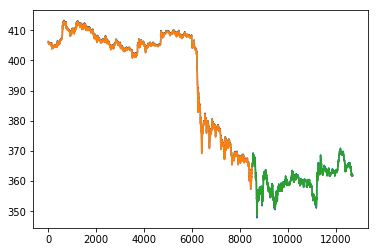

In [20]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [22]:
trainX[0]

array([[0.89263383]])

In [23]:
model.save('eth_model.h5')

In [82]:
from sklearn.externals import joblib
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

['scaler.save']

In [32]:
scaler.fit_transform([[1500.,1400.]])

array([[0., 0.]])

In [9]:
df = pd.read_csv("log_eth1.csv")

def predict_price(spot_price):
    ndf = (df[['spot_price']]).iloc[[1]]
    ndf['spot_price'] = spot_price
    ndf = scaler.transform(ndf)
    ndf = np.reshape(ndf, (ndf.shape[0], 1, ndf.shape[1]))
    t_pred = model.predict(ndf)
    return scaler.inverse_transform(t_pred)

In [78]:
ndf

array([[[-2.25346957]]])

In [4]:
from keras.models import load_model
model = load_model('eth_model.h5')
from sklearn.externals import joblib
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [67]:
max(df['spot_price']),min(df['spot_price'])

(413.33, 347.76)

In [58]:
adf = pd.read_csv("log_eth2.csv")
tol = 0.3

diff = []
prof = []
actual = []
for i, sp in enumerate(adf['spot_price']):
    pred_price = predict_price(sp)
    print(sp, pred_price, pred_price - sp,df['spot_price'].iloc[i+1] - sp)
    if pred_price-sp > tol:
        print('*'*50)
        try:
            diff.append(df['spot_price'].iloc[i+1] - pred_price)
            prof.append(df['spot_price'].iloc[i+1] - pred_price - 0.3)
            actual.append(df['spot_price'].iloc[i+1] - sp)
        except IndexError:
            pass

406.29 [[406.04724]] [[-0.24276733]] 0.0
406.29 [[406.04724]] [[-0.24276733]] 0.0
406.29 [[406.04724]] [[-0.24276733]] 0.0
406.29 [[406.04724]] [[-0.24276733]] 0.0
406.0 [[405.7566]] [[-0.2434082]] 0.29000000000002046
405.8 [[405.556]] [[-0.24398804]] 0.4900000000000091
405.78 [[405.53595]] [[-0.24404907]] 0.22000000000002728
405.77 [[405.52594]] [[-0.24404907]] 0.03000000000002956
405.67 [[405.4256]] [[-0.24441528]] 0.1099999999999568
405.7 [[405.45572]] [[-0.24429321]] 0.06999999999999318
405.54 [[405.29514]] [[-0.24487305]] 0.12999999999999545
405.69 [[405.44568]] [[-0.24432373]] -0.01999999999998181
405.7 [[405.45572]] [[-0.24429321]] 0.0
405.7 [[405.45572]] [[-0.24429321]] -0.15999999999996817
406.0 [[405.7566]] [[-0.2434082]] -0.3100000000000023
406.0 [[405.7566]] [[-0.2434082]] -0.30000000000001137
406.0 [[405.7566]] [[-0.2434082]] -0.30000000000001137
406.0 [[405.7566]] [[-0.2434082]] 0.0
406.0 [[405.7566]] [[-0.2434082]] 0.0
406.0 [[405.7566]] [[-0.2434082]] 0.0
406.0 [[405.75

404.46 [[404.20972]] [[-0.25027466]] 0.0
404.46 [[404.20972]] [[-0.25027466]] 0.3199999999999932
404.46 [[404.20972]] [[-0.25027466]] 0.0
404.47 [[404.2198]] [[-0.25021362]] -0.010000000000047748
404.47 [[404.2198]] [[-0.25021362]] -0.010000000000047748
404.47 [[404.2198]] [[-0.25021362]] -0.010000000000047748
404.64 [[404.3908]] [[-0.24920654]] -0.16999999999995907
404.56 [[404.31033]] [[-0.2496643]] -0.08999999999997499
404.8 [[404.5517]] [[-0.24829102]] -0.160000000000025
404.8 [[404.5517]] [[-0.24829102]] -0.2400000000000091
404.8 [[404.5517]] [[-0.24829102]] 0.0
404.86 [[404.61206]] [[-0.2479248]] -0.060000000000002274
404.7 [[404.45117]] [[-0.24884033]] 0.10000000000002274
404.66 [[404.41092]] [[-0.24908447]] 0.19999999999998863
404.66 [[404.41092]] [[-0.24908447]] 0.19999999999998863
404.74 [[404.4914]] [[-0.24859619]] -0.040000000000020464
404.66 [[404.41092]] [[-0.24908447]] 0.0
404.66 [[404.41092]] [[-0.24908447]] 0.0
404.66 [[404.41092]] [[-0.24908447]] 0.07999999999998408
4

405.0 [[404.75278]] [[-0.2472229]] 0.08999999999997499
405.0 [[404.75278]] [[-0.2472229]] 0.13999999999998636
405.0 [[404.75278]] [[-0.2472229]] 0.0
405.0 [[404.75278]] [[-0.2472229]] 0.0
405.0 [[404.75278]] [[-0.2472229]] 0.0
405.0 [[404.75278]] [[-0.2472229]] 0.0
405.0 [[404.75278]] [[-0.2472229]] 0.0
405.0 [[404.75278]] [[-0.2472229]] 0.0
405.07 [[404.82312]] [[-0.2468872]] -0.06999999999999318
405.2 [[404.95374]] [[-0.24627686]] -0.19999999999998863
405.2 [[404.95374]] [[-0.24627686]] -0.19999999999998863
404.73 [[404.48132]] [[-0.24868774]] 0.339999999999975
404.73 [[404.48132]] [[-0.24868774]] 0.46999999999997044
404.55 [[404.30026]] [[-0.24972534]] 0.6499999999999773
404.55 [[404.30026]] [[-0.24972534]] 0.18000000000000682
405.13 [[404.88342]] [[-0.24658203]] -0.5799999999999841
405.24 [[404.9939]] [[-0.24609375]] -0.6899999999999977
405.24 [[404.9939]] [[-0.24609375]] -0.11000000000001364
404.59 [[404.3405]] [[-0.2494812]] 0.6500000000000341
404.59 [[404.3405]] [[-0.2494812]] 0

406.53 [[406.2876]] [[-0.24240112]] -0.1099999999999568
406.53 [[406.2876]] [[-0.24240112]] -0.1099999999999568
406.93 [[406.6879]] [[-0.24209595]] -0.5099999999999909
406.93 [[406.6879]] [[-0.24209595]] -0.4000000000000341
406.93 [[406.6879]] [[-0.24209595]] -0.4000000000000341
406.93 [[406.6879]] [[-0.24209595]] 0.0
406.93 [[406.6879]] [[-0.24209595]] 0.0
406.93 [[406.6879]] [[-0.24209595]] 0.0
406.93 [[406.6879]] [[-0.24209595]] 0.0
406.88 [[406.63788]] [[-0.24212646]] 0.05000000000001137
406.88 [[406.63788]] [[-0.24212646]] 0.05000000000001137
406.68 [[406.43774]] [[-0.24224854]] 0.19999999999998863
406.98 [[406.7379]] [[-0.24209595]] -0.10000000000002274
406.99 [[406.74792]] [[-0.24206543]] -0.3100000000000023
407.13 [[406.88788]] [[-0.24212646]] -0.14999999999997726
407.2 [[406.95786]] [[-0.24215698]] -0.20999999999997954
407.17 [[406.9279]] [[-0.24212646]] -0.18000000000000682
407.18 [[406.93787]] [[-0.24212646]] -0.05000000000001137
407.07 [[406.82788]] [[-0.24212646]] 0.129999

413.15 [[412.85696]] [[-0.2930298]] -0.009999999999990905
413.14 [[412.84714]] [[-0.2928772]] 0.18999999999999773
413.14 [[412.84714]] [[-0.2928772]] 0.18999999999999773
413.14 [[412.84714]] [[-0.2928772]] 0.009999999999990905
413.11 [[412.81763]] [[-0.2923584]] 0.029999999999972715
412.82 [[412.53238]] [[-0.28762817]] 0.3199999999999932
412.81 [[412.52255]] [[-0.28744507]] 0.30000000000001137
412.81 [[412.52255]] [[-0.28744507]] 0.009999999999990905
412.81 [[412.52255]] [[-0.28744507]] 0.0
412.76 [[412.47336]] [[-0.2866516]] 0.05000000000001137
412.76 [[412.47336]] [[-0.2866516]] 0.05000000000001137
412.76 [[412.47336]] [[-0.2866516]] 0.05000000000001137
412.76 [[412.47336]] [[-0.2866516]] 0.0
412.65 [[412.36508]] [[-0.2849121]] 0.11000000000001364
412.64 [[412.35522]] [[-0.28479004]] 0.12000000000000455
412.64 [[412.35522]] [[-0.28479004]] 0.12000000000000455
412.57 [[412.28632]] [[-0.2836914]] 0.07999999999998408
412.01 [[411.73444]] [[-0.27557373]] 0.6299999999999955
412.01 [[411.7

410.47 [[410.2121]] [[-0.25790405]] 0.0
410.62 [[410.36066]] [[-0.25933838]] -0.14999999999997726
410.62 [[410.36066]] [[-0.25933838]] -0.14999999999997726
410.62 [[410.36066]] [[-0.25933838]] -0.14999999999997726
410.62 [[410.36066]] [[-0.25933838]] 0.0
410.62 [[410.36066]] [[-0.25933838]] 0.0
410.62 [[410.36066]] [[-0.25933838]] 0.0
410.62 [[410.36066]] [[-0.25933838]] 0.0
410.62 [[410.36066]] [[-0.25933838]] 0.0
410.61 [[410.35074]] [[-0.25924683]] 0.009999999999990905
410.61 [[410.35074]] [[-0.25924683]] 0.009999999999990905
410.61 [[410.35074]] [[-0.25924683]] 0.0
410.41 [[410.15265]] [[-0.25735474]] 0.19999999999998863
410.41 [[410.15265]] [[-0.25735474]] 0.19999999999998863
410.41 [[410.15265]] [[-0.25735474]] 0.19999999999998863
410.41 [[410.15265]] [[-0.25735474]] 0.0
410.41 [[410.15265]] [[-0.25735474]] 0.0
410.27 [[410.0139]] [[-0.25610352]] 0.1400000000000432
410.01 [[409.75607]] [[-0.25393677]] 0.4000000000000341
410.01 [[409.75607]] [[-0.25393677]] 0.4000000000000341
410.

410.29 [[410.03372]] [[-0.25628662]] -0.25
410.29 [[410.03372]] [[-0.25628662]] 0.0
410.29 [[410.03372]] [[-0.25628662]] 0.0
410.29 [[410.03372]] [[-0.25628662]] 0.0
410.29 [[410.03372]] [[-0.25628662]] 0.0
410.69 [[410.42996]] [[-0.26004028]] -0.39999999999997726
410.3 [[410.0436]] [[-0.25637817]] -0.009999999999990905
410.3 [[410.0436]] [[-0.25637817]] 0.38999999999998636
410.3 [[410.0436]] [[-0.25637817]] 0.0
410.3 [[410.0436]] [[-0.25637817]] 0.0
410.3 [[410.0436]] [[-0.25637817]] 0.0
410.3 [[410.0436]] [[-0.25637817]] 0.0
410.3 [[410.0436]] [[-0.25637817]] 0.0
410.3 [[410.0436]] [[-0.25637817]] 0.0
410.3 [[410.0436]] [[-0.25637817]] 0.0
410.3 [[410.0436]] [[-0.25637817]] 0.0
410.3 [[410.0436]] [[-0.25637817]] 0.0
410.3 [[410.0436]] [[-0.25637817]] 0.0
410.3 [[410.0436]] [[-0.25637817]] 0.0
410.3 [[410.0436]] [[-0.25637817]] 0.0
410.3 [[410.0436]] [[-0.25637817]] 0.0
410.3 [[410.0436]] [[-0.25637817]] 0.0
410.3 [[410.0436]] [[-0.25637817]] 0.0
410.3 [[410.0436]] [[-0.25637817]] 0.0

412.19 [[411.9119]] [[-0.2781067]] -1.3000000000000114
412.59 [[412.306]] [[-0.28399658]] -1.589999999999975
412.59 [[412.306]] [[-0.28399658]] -0.8599999999999568
412.41 [[412.1287]] [[-0.28131104]] -0.22000000000002728
411.7 [[411.42853]] [[-0.27148438]] 0.8899999999999864
411.7 [[411.42853]] [[-0.27148438]] 0.7100000000000364
411.75 [[411.47787]] [[-0.27212524]] -0.05000000000001137
412.25 [[411.97107]] [[-0.27893066]] -0.5500000000000114
411.7 [[411.42853]] [[-0.27148438]] 0.0
411.7 [[411.42853]] [[-0.27148438]] 0.05000000000001137
412.06 [[411.78375]] [[-0.27624512]] 0.18999999999999773
411.71 [[411.4384]] [[-0.27160645]] -0.009999999999990905
411.7 [[411.42853]] [[-0.27148438]] 0.0
411.7 [[411.42853]] [[-0.27148438]] 0.36000000000001364
411.51 [[411.2409]] [[-0.269104]] 0.19999999999998863
411.56 [[411.29025]] [[-0.26974487]] 0.13999999999998636
412.06 [[411.78375]] [[-0.27624512]] -0.5500000000000114
412.06 [[411.78375]] [[-0.27624512]] -0.5
412.06 [[411.78375]] [[-0.27624512]] 

412.1 [[411.82318]] [[-0.27682495]] 0.0
412.1 [[411.82318]] [[-0.27682495]] 0.0
412.1 [[411.82318]] [[-0.27682495]] 0.0
412.1 [[411.82318]] [[-0.27682495]] 0.0
412.21 [[411.93164]] [[-0.27835083]] -0.1099999999999568
412.21 [[411.93164]] [[-0.27835083]] -0.1099999999999568
412.25 [[411.97107]] [[-0.27893066]] -0.040000000000020464
412.4 [[412.11887]] [[-0.28112793]] -0.18999999999999773
412.4 [[412.11887]] [[-0.28112793]] -0.14999999999997726
412.4 [[412.11887]] [[-0.28112793]] 0.0
412.4 [[412.11887]] [[-0.28112793]] 0.0
412.4 [[412.11887]] [[-0.28112793]] 0.0
412.4 [[412.11887]] [[-0.28112793]] 0.0
412.4 [[412.11887]] [[-0.28112793]] 0.0
412.01 [[411.73444]] [[-0.27557373]] 0.38999999999998636
412.01 [[411.73444]] [[-0.27557373]] 0.38999999999998636
411.75 [[411.47787]] [[-0.27212524]] 0.6499999999999773
411.71 [[411.4384]] [[-0.27160645]] 0.30000000000001137
411.64 [[411.36926]] [[-0.27075195]] 0.11000000000001364
411.64 [[411.36926]] [[-0.27075195]] 0.06999999999999318
411.64 [[411.

412.26 [[411.9809]] [[-0.27911377]] 0.0
412.26 [[411.9809]] [[-0.27911377]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.14999999999997726
412.11 [[411.83304]] [[-0.27694702]] 0.14999999999997726
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.27694702]] 0.0
412.11 [[411.83304]] [[-0.2

411.2 [[410.93454]] [[-0.2654724]] 0.0
411.2 [[410.93454]] [[-0.2654724]] 0.0
411.2 [[410.93454]] [[-0.2654724]] 0.0
411.2 [[410.93454]] [[-0.2654724]] 0.0
411.2 [[410.93454]] [[-0.2654724]] 0.0
411.2 [[410.93454]] [[-0.2654724]] 0.0
411.2 [[410.93454]] [[-0.2654724]] 0.0
411.2 [[410.93454]] [[-0.2654724]] 0.0
411.2 [[410.93454]] [[-0.2654724]] 0.0
411.2 [[410.93454]] [[-0.2654724]] 0.0
411.2 [[410.93454]] [[-0.2654724]] 0.0
411.2 [[410.93454]] [[-0.2654724]] 0.0
411.2 [[410.93454]] [[-0.2654724]] 0.0
410.78 [[410.51904]] [[-0.2609558]] 0.4200000000000159
410.85 [[410.58835]] [[-0.2616577]] 0.3499999999999659
410.85 [[410.58835]] [[-0.2616577]] -0.07000000000005002
410.5 [[410.24182]] [[-0.2581787]] 0.35000000000002274
410.5 [[410.24182]] [[-0.2581787]] 0.35000000000002274
410.5 [[410.24182]] [[-0.2581787]] 0.0
410.85 [[410.58835]] [[-0.2616577]] -0.35000000000002274
410.85 [[410.58835]] [[-0.2616577]] -0.35000000000002274
410.85 [[410.58835]] [[-0.2616577]] 0.0
410.85 [[410.58835]] [[

410.41 [[410.15265]] [[-0.25735474]] 0.0
410.41 [[410.15265]] [[-0.25735474]] 0.0
410.41 [[410.15265]] [[-0.25735474]] 0.0
410.29 [[410.03372]] [[-0.25628662]] 0.12000000000000455
410.41 [[410.15265]] [[-0.25735474]] 0.0
410.41 [[410.15265]] [[-0.25735474]] 0.0
410.14 [[409.885]] [[-0.25500488]] 0.1500000000000341
410.14 [[409.885]] [[-0.25500488]] 0.27000000000003865
409.66 [[409.4087]] [[-0.25131226]] 0.75
409.65 [[409.39877]] [[-0.2512207]] 0.4900000000000091
409.42 [[409.17032]] [[-0.24969482]] 0.2400000000000091
409.21 [[408.96158]] [[-0.24841309]] 0.4399999999999977
409.18 [[408.93176]] [[-0.24822998]] 0.2400000000000091
409.44 [[409.1902]] [[-0.2498169]] -0.2300000000000182
409.44 [[409.1902]] [[-0.2498169]] -0.2599999999999909
409.43 [[409.18024]] [[-0.24975586]] 0.009999999999990905
409.16 [[408.91187]] [[-0.24813843]] 0.2799999999999727
409.16 [[408.91187]] [[-0.24813843]] 0.2699999999999818
409.16 [[408.91187]] [[-0.24813843]] 0.0
408.86 [[408.61346]] [[-0.246521]] 0.3000000

406.69 [[406.44775]] [[-0.24224854]] 0.12999999999999545
406.91 [[406.6679]] [[-0.24209595]] -0.7600000000000477
406.91 [[406.6679]] [[-0.24209595]] -0.22000000000002728
406.95 [[406.7079]] [[-0.24212646]] -0.03999999999996362
406.95 [[406.7079]] [[-0.24212646]] -0.03999999999996362
407.08 [[406.8379]] [[-0.24209595]] -0.16999999999995907
407.6 [[407.35748]] [[-0.2425232]] -0.6500000000000341
407.6 [[407.35748]] [[-0.2425232]] -0.5200000000000387
407.6 [[407.35748]] [[-0.2425232]] 0.0
407.6 [[407.35748]] [[-0.2425232]] 0.0
407.6 [[407.35748]] [[-0.2425232]] 0.0
407.6 [[407.35748]] [[-0.2425232]] 0.0
407.6 [[407.35748]] [[-0.2425232]] 0.0
407.6 [[407.35748]] [[-0.2425232]] 0.0
407.6 [[407.35748]] [[-0.2425232]] 0.0
407.6 [[407.35748]] [[-0.2425232]] 0.0
407.6 [[407.35748]] [[-0.2425232]] 0.0
407.6 [[407.35748]] [[-0.2425232]] 0.0
407.6 [[407.35748]] [[-0.2425232]] 0.0
407.6 [[407.35748]] [[-0.2425232]] 0.0
407.6 [[407.35748]] [[-0.2425232]] 0.0
407.6 [[407.35748]] [[-0.2425232]] 0.0
407

406.01 [[405.7666]] [[-0.2434082]] 0.0
406.01 [[405.7666]] [[-0.2434082]] 0.0
406.51 [[406.26758]] [[-0.24243164]] -0.5
406.51 [[406.26758]] [[-0.24243164]] -0.5
406.51 [[406.26758]] [[-0.24243164]] 0.0
406.51 [[406.26758]] [[-0.24243164]] 0.0
406.24 [[405.99716]] [[-0.24282837]] 0.2699999999999818
406.21 [[405.96707]] [[-0.24291992]] 0.30000000000001137
406.21 [[405.96707]] [[-0.24291992]] 0.03000000000002956
406.21 [[405.96707]] [[-0.24291992]] 0.03000000000002956
406.21 [[405.96707]] [[-0.24291992]] 0.0
406.46 [[406.2175]] [[-0.24249268]] -0.25
406.46 [[406.2175]] [[-0.24249268]] -0.25
406.46 [[406.2175]] [[-0.24249268]] 0.0
406.46 [[406.2175]] [[-0.24249268]] 0.0
406.47 [[406.2275]] [[-0.24249268]] -0.010000000000047748
406.47 [[406.2275]] [[-0.24249268]] -0.010000000000047748
406.47 [[406.2275]] [[-0.24249268]] 0.0
406.47 [[406.2275]] [[-0.24249268]] 0.0
406.47 [[406.2275]] [[-0.24249268]] 0.0
406.74 [[406.4978]] [[-0.2421875]] -0.2699999999999818
406.74 [[406.4978]] [[-0.2421875]

407.81 [[407.56708]] [[-0.24291992]] -0.13999999999998636
408.18 [[407.93616]] [[-0.24383545]] -0.5099999999999909
407.67 [[407.42737]] [[-0.24264526]] 0.13999999999998636
407.67 [[407.42737]] [[-0.24264526]] 0.5099999999999909
407.67 [[407.42737]] [[-0.24264526]] 0.0
407.67 [[407.42737]] [[-0.24264526]] 0.0
407.67 [[407.42737]] [[-0.24264526]] 0.0
407.67 [[407.42737]] [[-0.24264526]] 0.0
407.67 [[407.42737]] [[-0.24264526]] 0.0
407.67 [[407.42737]] [[-0.24264526]] 0.0
407.67 [[407.42737]] [[-0.24264526]] 0.0
407.58 [[407.3375]] [[-0.24249268]] 0.09000000000003183
407.58 [[407.3375]] [[-0.24249268]] 0.09000000000003183
407.58 [[407.3375]] [[-0.24249268]] 0.09000000000003183
407.58 [[407.3375]] [[-0.24249268]] 0.0
407.58 [[407.3375]] [[-0.24249268]] 0.0
407.58 [[407.3375]] [[-0.24249268]] 0.0
407.58 [[407.3375]] [[-0.24249268]] 0.0
407.68 [[407.43732]] [[-0.24267578]] -0.10000000000002274
407.68 [[407.43732]] [[-0.24267578]] -0.10000000000002274
407.68 [[407.43732]] [[-0.24267578]] 0.0


405.31 [[405.06424]] [[-0.24575806]] 0.0
405.29 [[405.04413]] [[-0.24588013]] 0.01999999999998181
405.29 [[405.04413]] [[-0.24588013]] 0.01999999999998181
405.29 [[405.04413]] [[-0.24588013]] 0.0
405.29 [[405.04413]] [[-0.24588013]] 0.0
405.29 [[405.04413]] [[-0.24588013]] 0.0
405.29 [[405.04413]] [[-0.24588013]] 0.0
405.29 [[405.04413]] [[-0.24588013]] 0.0
405.26 [[405.01398]] [[-0.24603271]] 0.03000000000002956
405.16 [[404.91354]] [[-0.24645996]] 0.12999999999999545
405.11 [[404.8633]] [[-0.24667358]] 0.14999999999997726
405.11 [[404.8633]] [[-0.24667358]] 0.05000000000001137
405.11 [[404.8633]] [[-0.24667358]] 0.0
405.01 [[404.76282]] [[-0.24719238]] 0.10000000000002274
405.01 [[404.76282]] [[-0.24719238]] 0.10000000000002274
404.91 [[404.66232]] [[-0.24768066]] 0.0999999999999659
404.91 [[404.66232]] [[-0.24768066]] 0.0999999999999659
404.91 [[404.66232]] [[-0.24768066]] 0.0
404.91 [[404.66232]] [[-0.24768066]] 0.0
404.91 [[404.66232]] [[-0.24768066]] 0.0
404.91 [[404.66232]] [[-0

404.76 [[404.5115]] [[-0.24850464]] -0.07999999999998408
404.76 [[404.5115]] [[-0.24850464]] -0.07999999999998408
404.76 [[404.5115]] [[-0.24850464]] -0.07999999999998408
404.6 [[404.3506]] [[-0.24942017]] 0.15999999999996817
404.6 [[404.3506]] [[-0.24942017]] 0.15999999999996817
404.6 [[404.3506]] [[-0.24942017]] 0.0
404.6 [[404.3506]] [[-0.24942017]] 0.0
404.27 [[404.01846]] [[-0.25152588]] 0.3300000000000409
404.21 [[403.9581]] [[-0.2518921]] 0.3900000000000432
404.48 [[404.22986]] [[-0.2501526]] -0.21000000000003638
404.12 [[403.86746]] [[-0.25253296]] 0.08999999999997499
404.11 [[403.8574]] [[-0.252594]] 0.0999999999999659
404.11 [[403.8574]] [[-0.252594]] 0.37000000000000455
404.11 [[403.8574]] [[-0.252594]] 0.009999999999990905
404.11 [[403.8574]] [[-0.252594]] 0.0
404.37 [[404.11914]] [[-0.2508545]] -0.2599999999999909
404.37 [[404.11914]] [[-0.2508545]] -0.2599999999999909
404.73 [[404.48132]] [[-0.24868774]] -0.36000000000001364
404.73 [[404.48132]] [[-0.24868774]] -0.3600000

406.19 [[405.94702]] [[-0.24298096]] 0.0
406.28 [[406.0372]] [[-0.24279785]] -0.08999999999997499
406.28 [[406.0372]] [[-0.24279785]] -0.08999999999997499
406.28 [[406.0372]] [[-0.24279785]] 0.0
406.28 [[406.0372]] [[-0.24279785]] 0.0
406.19 [[405.94702]] [[-0.24298096]] 0.08999999999997499
406.01 [[405.7666]] [[-0.2434082]] 0.2699999999999818
406.01 [[405.7666]] [[-0.2434082]] 0.18000000000000682
406.01 [[405.7666]] [[-0.2434082]] 0.0
406.03 [[405.78665]] [[-0.24334717]] -0.01999999999998181
406.05 [[405.8067]] [[-0.24328613]] -0.040000000000020464
406.05 [[405.8067]] [[-0.24328613]] -0.020000000000038654
406.05 [[405.8067]] [[-0.24328613]] 0.0
406.05 [[405.8067]] [[-0.24328613]] 0.0
406.16 [[405.917]] [[-0.24301147]] -0.11000000000001364
406.16 [[405.917]] [[-0.24301147]] -0.11000000000001364
406.3 [[406.05725]] [[-0.24273682]] -0.13999999999998636
406.34 [[406.09732]] [[-0.24267578]] -0.17999999999994998
406.34 [[406.09732]] [[-0.24267578]] -0.03999999999996362
406.15 [[405.90695]] 

404.58 [[404.33047]] [[-0.24951172]] -0.01999999999998181
404.58 [[404.33047]] [[-0.24951172]] -0.05000000000001137
404.58 [[404.33047]] [[-0.24951172]] 0.0
404.58 [[404.33047]] [[-0.24951172]] 0.0
404.58 [[404.33047]] [[-0.24951172]] 0.0
404.58 [[404.33047]] [[-0.24951172]] 0.0
404.58 [[404.33047]] [[-0.24951172]] 0.0
404.58 [[404.33047]] [[-0.24951172]] 0.0
404.58 [[404.33047]] [[-0.24951172]] 0.0
404.58 [[404.33047]] [[-0.24951172]] 0.0
404.58 [[404.33047]] [[-0.24951172]] 0.0
404.58 [[404.33047]] [[-0.24951172]] 0.0
404.58 [[404.33047]] [[-0.24951172]] 0.0
404.58 [[404.33047]] [[-0.24951172]] 0.0
404.58 [[404.33047]] [[-0.24951172]] 0.0
404.58 [[404.33047]] [[-0.24951172]] 0.0
404.58 [[404.33047]] [[-0.24951172]] 0.0
404.59 [[404.3405]] [[-0.2494812]] -0.009999999999990905
404.74 [[404.4914]] [[-0.24859619]] -0.160000000000025
404.74 [[404.4914]] [[-0.24859619]] -0.160000000000025
404.8 [[404.5517]] [[-0.24829102]] -0.21000000000003638
404.8 [[404.5517]] [[-0.24829102]] -0.06000000

403.54 [[403.28296]] [[-0.25704956]] -0.060000000000002274
403.66 [[403.40393]] [[-0.256073]] -0.160000000000025
403.66 [[403.40393]] [[-0.256073]] -0.12000000000000455
403.76 [[403.50473]] [[-0.25527954]] -0.21999999999997044
403.97 [[403.71637]] [[-0.2536316]] -0.3100000000000023
403.96 [[403.70627]] [[-0.25372314]] -0.19999999999998863
403.93 [[403.67606]] [[-0.25393677]] 0.040000000000020464
403.96 [[403.70627]] [[-0.25372314]] 0.0
403.96 [[403.70627]] [[-0.25372314]] -0.029999999999972715
404.0 [[403.74658]] [[-0.25341797]] -0.040000000000020464
404.0 [[403.74658]] [[-0.25341797]] -0.040000000000020464
404.2 [[403.948]] [[-0.25201416]] -0.19999999999998863
404.2 [[403.948]] [[-0.25201416]] -0.19999999999998863
404.2 [[403.948]] [[-0.25201416]] 0.0
404.2 [[403.948]] [[-0.25201416]] 0.0
404.16 [[403.9077]] [[-0.25228882]] 0.03999999999996362
404.16 [[403.9077]] [[-0.25228882]] 0.03999999999996362
404.16 [[403.9077]] [[-0.25228882]] 0.0
404.16 [[403.9077]] [[-0.25228882]] 0.0
403.78 

404.04 [[403.78687]] [[-0.2531433]] 0.12999999999999545
404.17 [[403.9178]] [[-0.25222778]] 0.0
404.03 [[403.7768]] [[-0.25320435]] 0.010000000000047748
404.03 [[403.7768]] [[-0.25320435]] 0.1400000000000432
404.03 [[403.7768]] [[-0.25320435]] 0.0
404.03 [[403.7768]] [[-0.25320435]] 0.0
404.03 [[403.7768]] [[-0.25320435]] 0.0
404.03 [[403.7768]] [[-0.25320435]] 0.0
404.03 [[403.7768]] [[-0.25320435]] 0.0
404.03 [[403.7768]] [[-0.25320435]] 0.0
404.03 [[403.7768]] [[-0.25320435]] 0.0
404.03 [[403.7768]] [[-0.25320435]] 0.0
404.03 [[403.7768]] [[-0.25320435]] 0.0
404.03 [[403.7768]] [[-0.25320435]] 0.0
404.03 [[403.7768]] [[-0.25320435]] 0.0
404.03 [[403.7768]] [[-0.25320435]] 0.0
404.09 [[403.83725]] [[-0.25274658]] -0.060000000000002274
404.07 [[403.81708]] [[-0.2529297]] -0.040000000000020464
404.2 [[403.948]] [[-0.25201416]] -0.11000000000001364
404.19 [[403.93793]] [[-0.2520752]] -0.12000000000000455
404.22 [[403.96814]] [[-0.25186157]] -0.020000000000038654
404.31 [[404.05875]] [[-

402.3 [[402.03082]] [[-0.26916504]] 0.12999999999999545
402.3 [[402.03082]] [[-0.26916504]] 0.12999999999999545
402.25 [[401.98026]] [[-0.26974487]] 0.06999999999999318
402.25 [[401.98026]] [[-0.26974487]] 0.05000000000001137
402.25 [[401.98026]] [[-0.26974487]] 0.0
402.25 [[401.98026]] [[-0.26974487]] 0.0
402.25 [[401.98026]] [[-0.26974487]] 0.0
402.25 [[401.98026]] [[-0.26974487]] 0.0
402.25 [[401.98026]] [[-0.26974487]] 0.0
402.25 [[401.98026]] [[-0.26974487]] 0.0
402.5 [[402.233]] [[-0.2669983]] -0.25
402.46 [[402.19257]] [[-0.26742554]] -0.20999999999997954
402.49 [[402.22287]] [[-0.26712036]] 0.009999999999990905
402.25 [[401.98026]] [[-0.26974487]] 0.20999999999997954
402.25 [[401.98026]] [[-0.26974487]] 0.20999999999997954
402.25 [[401.98026]] [[-0.26974487]] 0.2400000000000091
402.25 [[401.98026]] [[-0.26974487]] 0.0
402.25 [[401.98026]] [[-0.26974487]] 0.0
402.25 [[401.98026]] [[-0.26974487]] 0.0
402.25 [[401.98026]] [[-0.26974487]] 0.0
402.25 [[401.98026]] [[-0.26974487]] 0.

402.43 [[402.16226]] [[-0.2677307]] -0.09000000000003183
402.37 [[402.1016]] [[-0.2684021]] 0.029999999999972715
402.43 [[402.16226]] [[-0.2677307]] 0.0
402.43 [[402.16226]] [[-0.2677307]] -0.060000000000002274
402.43 [[402.16226]] [[-0.2677307]] 0.0
402.43 [[402.16226]] [[-0.2677307]] 0.0
402.22 [[401.94992]] [[-0.27008057]] 0.20999999999997954
402.36 [[402.09146]] [[-0.26852417]] 0.06999999999999318
402.33 [[402.06113]] [[-0.26885986]] -0.1099999999999568
402.44 [[402.17236]] [[-0.26763916]] -0.07999999999998408
402.45 [[402.18246]] [[-0.2675476]] -0.12000000000000455
402.46 [[402.19257]] [[-0.26742554]] -0.01999999999998181
402.55 [[402.28354]] [[-0.26644897]] -0.10000000000002274
402.55 [[402.28354]] [[-0.26644897]] -0.10000000000002274
403.0 [[402.73807]] [[-0.26193237]] -0.5400000000000205
404.9 [[404.65225]] [[-0.2477417]] -2.349999999999966
405.1 [[404.85327]] [[-0.24673462]] -2.1000000000000227
405.1 [[404.85327]] [[-0.24673462]] -0.20000000000004547
405.1 [[404.85327]] [[-0.2

406.5 [[406.25757]] [[-0.24243164]] 0.18000000000000682
406.67 [[406.42773]] [[-0.24227905]] -0.17000000000001592
406.67 [[406.42773]] [[-0.24227905]] -0.17000000000001592
406.65 [[406.40775]] [[-0.24224854]] -0.14999999999997726
406.77 [[406.52783]] [[-0.24215698]] -0.0999999999999659
406.76 [[406.51782]] [[-0.2421875]] -0.11000000000001364
406.44 [[406.19748]] [[-0.2425232]] 0.3299999999999841
406.44 [[406.19748]] [[-0.2425232]] 0.3199999999999932
406.44 [[406.19748]] [[-0.2425232]] 0.0
406.32 [[406.07727]] [[-0.24273682]] 0.12000000000000455
406.32 [[406.07727]] [[-0.24273682]] 0.12000000000000455
406.32 [[406.07727]] [[-0.24273682]] 0.12000000000000455
406.32 [[406.07727]] [[-0.24273682]] 0.0
406.32 [[406.07727]] [[-0.24273682]] 0.0
405.91 [[405.66635]] [[-0.24365234]] 0.40999999999996817
405.71 [[405.46576]] [[-0.24423218]] 0.6100000000000136
405.71 [[405.46576]] [[-0.24423218]] 0.20000000000004547
405.71 [[405.46576]] [[-0.24423218]] 0.0
405.71 [[405.46576]] [[-0.24423218]] 0.0
4

403.59 [[403.33337]] [[-0.2566223]] 0.0
403.59 [[403.33337]] [[-0.2566223]] 0.0
403.59 [[403.33337]] [[-0.2566223]] 0.0
403.59 [[403.33337]] [[-0.2566223]] 0.0
403.59 [[403.33337]] [[-0.2566223]] 0.0
403.59 [[403.33337]] [[-0.2566223]] 0.0
403.59 [[403.33337]] [[-0.2566223]] 0.0
403.59 [[403.33337]] [[-0.2566223]] 0.0
403.59 [[403.33337]] [[-0.2566223]] 0.0
403.59 [[403.33337]] [[-0.2566223]] 0.0
403.59 [[403.33337]] [[-0.2566223]] 0.0
403.59 [[403.33337]] [[-0.2566223]] 0.0
403.59 [[403.33337]] [[-0.2566223]] 0.0
403.59 [[403.33337]] [[-0.2566223]] 0.0
403.59 [[403.33337]] [[-0.2566223]] 0.0
403.56 [[403.30313]] [[-0.25686646]] 0.029999999999972715
403.01 [[402.74817]] [[-0.26184082]] 0.5799999999999841
403.01 [[402.74817]] [[-0.26184082]] 0.5500000000000114
403.01 [[402.74817]] [[-0.26184082]] 0.0
402.75 [[402.4856]] [[-0.2644043]] 0.2599999999999909
403.02 [[402.75824]] [[-0.26174927]] -0.009999999999990905
403.02 [[402.75824]] [[-0.26174927]] -0.2699999999999818
403.02 [[402.75824]

405.53 [[405.2851]] [[-0.24490356]] 0.0
405.53 [[405.2851]] [[-0.24490356]] 0.0
405.53 [[405.2851]] [[-0.24490356]] 0.0
405.53 [[405.2851]] [[-0.24490356]] 0.0
405.74 [[405.49582]] [[-0.24417114]] -0.21000000000003638
405.74 [[405.49582]] [[-0.24417114]] -0.21000000000003638
405.74 [[405.49582]] [[-0.24417114]] 0.0
405.74 [[405.49582]] [[-0.24417114]] 0.0
405.74 [[405.49582]] [[-0.24417114]] 0.0
405.8 [[405.556]] [[-0.24398804]] -0.060000000000002274
405.8 [[405.556]] [[-0.24398804]] -0.060000000000002274
405.8 [[405.556]] [[-0.24398804]] 0.0
405.8 [[405.556]] [[-0.24398804]] 0.0
405.82 [[405.57608]] [[-0.243927]] -0.01999999999998181
405.82 [[405.57608]] [[-0.243927]] -0.01999999999998181
405.82 [[405.57608]] [[-0.243927]] -0.01999999999998181
405.82 [[405.57608]] [[-0.243927]] 0.0
405.82 [[405.57608]] [[-0.243927]] 0.0
405.82 [[405.57608]] [[-0.243927]] 0.0
405.82 [[405.57608]] [[-0.243927]] 0.0
405.82 [[405.57608]] [[-0.243927]] 0.0
405.8 [[405.556]] [[-0.24398804]] 0.01999999999998

405.74 [[405.49582]] [[-0.24417114]] -0.4000000000000341
405.65 [[405.40552]] [[-0.24447632]] -0.21999999999997044
405.65 [[405.40552]] [[-0.24447632]] -0.21999999999997044
405.48 [[405.2349]] [[-0.24511719]] 0.2599999999999909
405.48 [[405.2349]] [[-0.24511719]] 0.16999999999995907
405.48 [[405.2349]] [[-0.24511719]] 0.0
405.46 [[405.21484]] [[-0.2451477]] 0.020000000000038654
405.48 [[405.2349]] [[-0.24511719]] 0.0
405.48 [[405.2349]] [[-0.24511719]] 0.0
405.48 [[405.2349]] [[-0.24511719]] -0.020000000000038654
405.48 [[405.2349]] [[-0.24511719]] 0.0
405.97 [[405.7265]] [[-0.24349976]] -0.4900000000000091
405.97 [[405.7265]] [[-0.24349976]] -0.4900000000000091
405.97 [[405.7265]] [[-0.24349976]] 0.0
405.97 [[405.7265]] [[-0.24349976]] 0.0
405.97 [[405.7265]] [[-0.24349976]] 0.0
406.0 [[405.7566]] [[-0.2434082]] -0.029999999999972715
405.97 [[405.7265]] [[-0.24349976]] 0.0
405.97 [[405.7265]] [[-0.24349976]] 0.029999999999972715
405.46 [[405.21484]] [[-0.2451477]] 0.5100000000000477
4

405.07 [[404.82312]] [[-0.2468872]] 0.0
405.07 [[404.82312]] [[-0.2468872]] 0.0
405.02 [[404.7729]] [[-0.24710083]] 0.05000000000001137
405.02 [[404.7729]] [[-0.24710083]] 0.05000000000001137
405.02 [[404.7729]] [[-0.24710083]] 0.0
404.81 [[404.56177]] [[-0.24822998]] 0.20999999999997954
404.81 [[404.56177]] [[-0.24822998]] 0.20999999999997954
404.81 [[404.56177]] [[-0.24822998]] 0.20999999999997954
404.81 [[404.56177]] [[-0.24822998]] 0.0
404.81 [[404.56177]] [[-0.24822998]] 0.0
405.08 [[404.83316]] [[-0.24682617]] -0.2699999999999818
405.08 [[404.83316]] [[-0.24682617]] -0.2699999999999818
405.08 [[404.83316]] [[-0.24682617]] -0.2699999999999818
405.08 [[404.83316]] [[-0.24682617]] 0.0
405.09 [[404.8432]] [[-0.24679565]] -0.009999999999990905
405.09 [[404.8432]] [[-0.24679565]] -0.009999999999990905
405.09 [[404.8432]] [[-0.24679565]] 0.0
405.09 [[404.8432]] [[-0.24679565]] 0.0
405.09 [[404.8432]] [[-0.24679565]] 0.0
405.09 [[404.8432]] [[-0.24679565]] 0.0
405.09 [[404.8432]] [[-0.24

KeyboardInterrupt: 

In [45]:
correct = int(sum(i > 0 for i in prof))
n = float(len(prof))
print(f"Profit: {correct / n * 100:,.2f}%")

ZeroDivisionError: float division by zero

In [56]:
len(adf['spot_price'])

10800